In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn import tree

The dataset that used in this experiment has been clean up so that it did not consists any variable that directly represent the dependent variable, Erbium concentration.

In [2]:
data = pd.read_csv('Structured_features.csv')
data

,Longitudinal modulus,Shear modulus,Bulk modulus,Young modulus,Poisson's ratio,Hardness,fractal bond connectivity,acoustic impedance,Erbium Concentration
0,60.505571,20.125896,33.671042,50.346610,0.250792,3.343693,2.390885,17.829646,0.01
1,61.749309,20.539600,34.363176,51.381524,0.250792,3.412425,2.390885,18.196148,0.01
2,60.206152,20.026301,33.504417,50.097465,0.250792,3.327146,2.390885,17.741414,0.01
3,62.014179,20.627703,34.510575,51.601922,0.250792,3.427063,2.390885,18.274199,0.01
4,62.831822,20.899675,34.965589,52.282281,0.250792,3.472248,2.390885,18.515140,0.01
...,...,...,...,...,...,...,...,...,...
245,58.273308,19.835527,31.825938,49.270607,0.241979,3.411991,2.493001,17.663388,0.05
246,57.141365,19.450228,31.207728,48.313539,0.241979,3.345714,2.493001,17.320282,0.05
247,61.777979,21.028475,33.740012,52.233838,0.241979,3.617195,2.493001,18.725699,0.05
248,58.251540,19.828118,31.814050,49.252202,0.241979,3.410717,2.493001,17.656790,0.05


In [3]:
# check if any NaN
data.isna().sum()

Longitudinal modulus         0
Shear modulus                0
Bulk modulus                 0
Young modulus                0
Poisson's ratio              0
Hardness                     0
fractal bond connectivity    0
acoustic impedance           0
Erbium Concentration         0
dtype: int64

In [4]:
# Note that we use random_state to ensure the reproducibility of the examples.
train_data = data.sample(frac=0.8, random_state=0)
test_data = data.drop(train_data.index)

print('Shape of training data :',train_data.shape)
print('Shape of testing data :',test_data.shape)

Shape of training data : (200, 9)
Shape of testing data : (50, 9)


In [5]:
train_data

,Longitudinal modulus,Shear modulus,Bulk modulus,Young modulus,Poisson's ratio,Hardness,fractal bond connectivity,acoustic impedance,Erbium Concentration
225,66.425882,19.892242,39.902892,51.173172,0.286260,2.834518,1.994065,18.858530,0.05
122,63.501343,18.969675,38.208442,48.828291,0.287009,2.693578,1.985915,18.613525,0.03
92,59.015531,20.495892,31.687674,50.582029,0.233955,3.635216,2.587238,17.925947,0.02
157,63.281998,20.478164,35.977780,51.637350,0.260791,3.265714,2.276757,18.496013,0.04
154,75.022997,24.277571,42.652902,61.217865,0.260791,3.871616,2.276757,21.927663,0.04
...,...,...,...,...,...,...,...,...,...
183,60.422223,19.767204,34.065950,49.690441,0.256891,3.203724,2.321051,17.844470,0.04
114,63.459155,20.283022,36.415126,51.320631,0.265113,3.176145,2.227978,18.391229,0.03
163,62.626366,19.779326,36.253932,50.207318,0.269187,3.043553,2.182310,18.167029,0.04
151,58.786939,19.023555,33.422199,47.969436,0.260791,3.033743,2.276757,17.182200,0.04


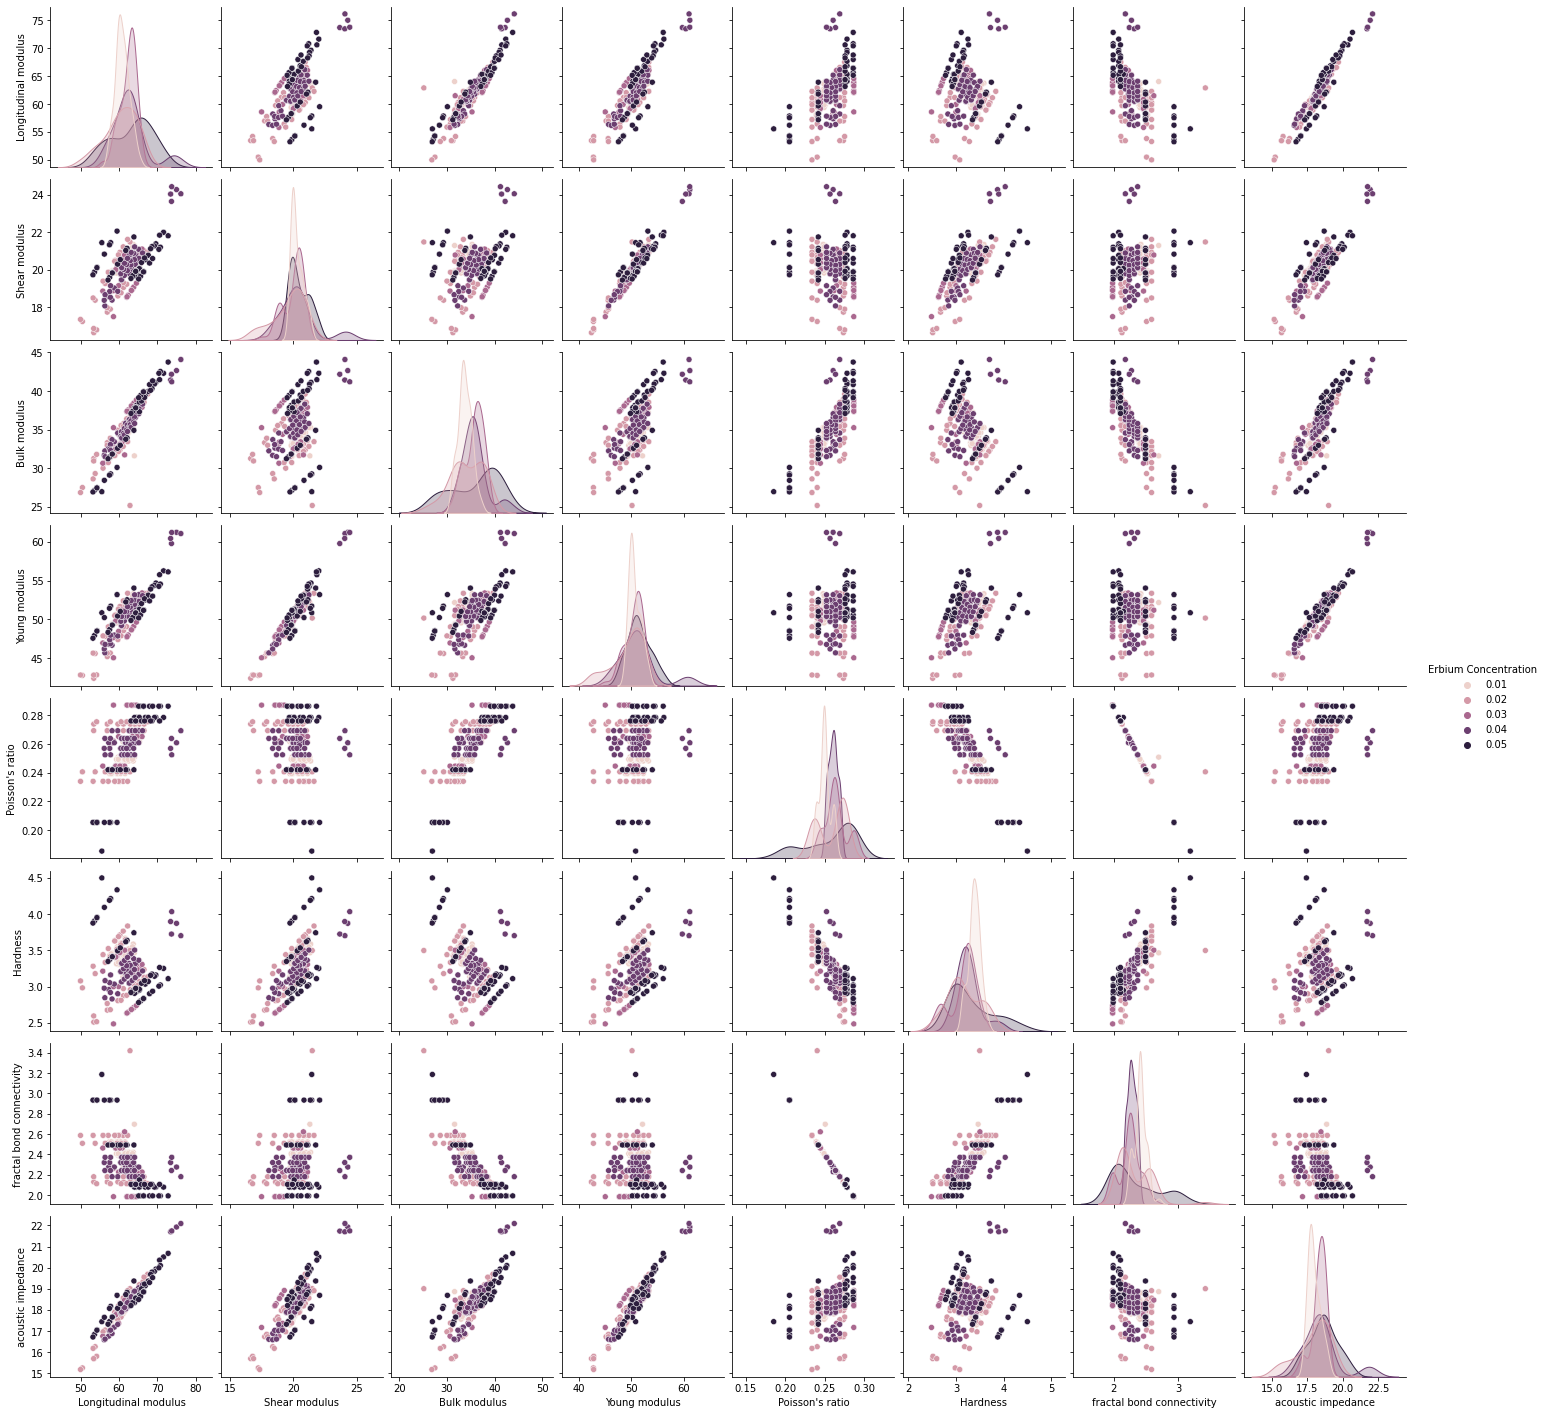

In [6]:
sns.pairplot(data, diag_kind='kde', hue="Erbium Concentration")

In [7]:
train_x = train_data.drop(columns=['Erbium Concentration'],axis=1)
train_y = train_data['Erbium Concentration'].astype(str)

test_x = test_data.drop(columns=['Erbium Concentration'],axis=1)
test_y = test_data['Erbium Concentration'].astype(str)

In [8]:
train_x[:5]

,Longitudinal modulus,Shear modulus,Bulk modulus,Young modulus,Poisson's ratio,Hardness,fractal bond connectivity,acoustic impedance
225,66.425882,19.892242,39.902892,51.173172,0.286260,2.834518,1.994065,18.858530
122,63.501343,18.969675,38.208442,48.828291,0.287009,2.693578,1.985915,18.613525
92,59.015531,20.495892,31.687674,50.582029,0.233955,3.635216,2.587238,17.925947
157,63.281998,20.478164,35.977780,51.637350,0.260791,3.265714,2.276757,18.496013
154,75.022997,24.277571,42.652902,61.217865,0.260791,3.871616,2.276757,21.927663


In [9]:
dt_model = tree.DecisionTreeClassifier(criterion='gini')
dt_model.fit(train_x, train_y)
dt_model.score(train_x, train_y)

1.0

In [10]:
prediction = dt_model.predict(test_x)
prediction

array(['0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01',
       '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.03',
       '0.02', '0.02', '0.02', '0.03', '0.03', '0.03', '0.03', '0.03',
       '0.03', '0.03', '0.03', '0.04', '0.04', '0.03', '0.03', '0.04',
       '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.02', '0.05',
       '0.05', '0.05', '0.05', '0.05', '0.05', '0.05', '0.05', '0.05',
       '0.05', '0.05'], dtype=object)

In [11]:
dt_test_accuracy = accuracy_score(test_y,prediction)
print('Gini test accuracy: ', dt_test_accuracy)

Gini test accuracy:  0.92


In [21]:
def accuracy(confusion_matrix):
  diagonal_sum = confusion_matrix.trace()
  sum_of_all_elements = confusion_matrix.sum()
  return diagonal_sum / sum_of_all_elements

def test_model(train_data, train_label, test_data, test_label):
  pred_y = dt_model.predict(test_data)
  train_acc = dt_model.score(train_data, train_label)
  test_acc = dt_model.score(test_data, test_label)

  print('Training Accuracy : %.3f'%train_acc)
  print('Test Accuracy : %.3f'%test_acc)

  plt.figure(figsize=(10,7))
  cm = confusion_matrix(pred_y, test_label)
  print("Accuracy score :", accuracy(cm))

  sns.set(font_scale=1.4) # for label size
  sns.heatmap(cm, annot=True, annot_kws={"size": 16})
  plt.show()

Training Accuracy : 1.000
Test Accuracy : 0.920
Accuracy score : 0.92


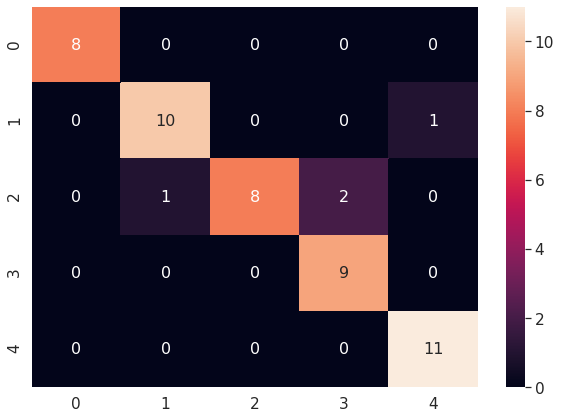

In [22]:
test_model(train_x, train_y, test_x, test_y)

# **Will normalized the data improve model accuracy?**

Training Accuracy : 0.210
Test Accuracy : 0.220
Accuracy score : 0.22


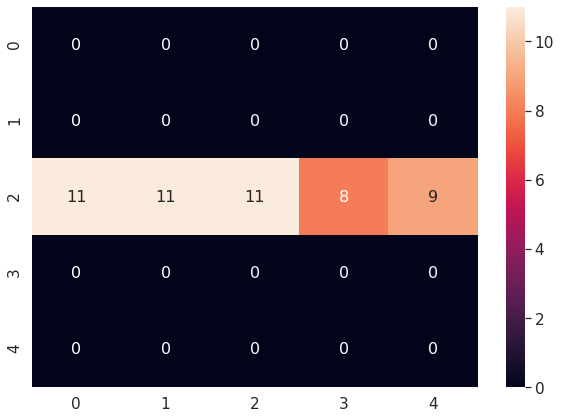

In [18]:
column_name = data.columns[:-1]
df_data = data.copy()
for column in column_name:
    df_data[column] = (df_data[column] - df_data[column].min()) / (df_data[column].max() - df_data[column].min())

normalized_train_data = df_data.sample(frac=0.8, random_state=10)
normalized_test_data = df_data.drop(normalized_train_data.index)

normalized_train_x = normalized_train_data.drop(columns=['Erbium Concentration'],axis=1)
normalized_train_y = normalized_train_data['Erbium Concentration'].astype(str)

normalized_test_x = normalized_test_data.drop(columns=['Erbium Concentration'],axis=1)
normalized_test_y = normalized_test_data['Erbium Concentration'].astype(str)

test_model(normalized_train_x, normalized_train_y, normalized_test_x, normalized_test_y)

Based on results, it is negative impact to model if normalized the input data. Why?

# **What are the optimum parameters that give maximum accuracy?**

In [34]:
parameter_space = {
    'criterion': ['gini','entropy'],
    'splitter': ['best','random'],
}

clf = GridSearchCV(dt_model, parameter_space, n_jobs=-1, cv=5)
clf.fit(train_x, train_y)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.925 (+/-0.100) for {'criterion': 'gini', 'splitter': 'best'}
0.940 (+/-0.129) for {'criterion': 'gini', 'splitter': 'random'}
0.960 (+/-0.068) for {'criterion': 'entropy', 'splitter': 'best'}
0.900 (+/-0.152) for {'criterion': 'entropy', 'splitter': 'random'}


In [35]:
print('Best parameters are:\n', clf.best_params_)

Best parameters are:
 {'criterion': 'entropy', 'splitter': 'best'}


Training Accuracy : 1.000
Test Accuracy : 0.920
Accuracy score : 0.92


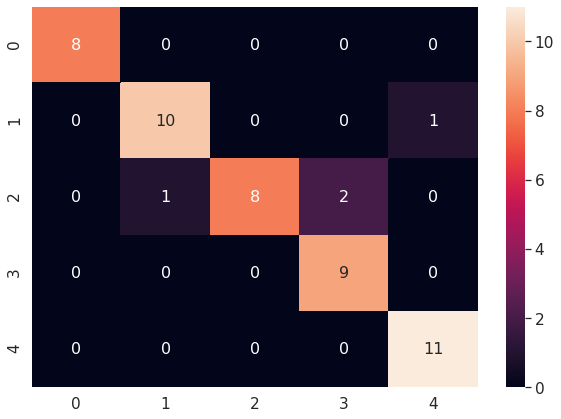

In [37]:
final_dt_model = tree.DecisionTreeClassifier(criterion='entropy', splitter='best')
final_dt_model.fit(train_x, train_y)

pred_y = final_dt_model.predict(test_x)
train_acc = final_dt_model.score(train_x, train_y)
test_acc = final_dt_model.score(test_x, test_y)

print('Training Accuracy : %.3f'%train_acc)
print('Test Accuracy : %.3f'%test_acc)

plt.figure(figsize=(10,7))
cm = confusion_matrix(pred_y, test_y)
print("Accuracy score :", accuracy(cm))

sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16})
plt.show()

# **If use cross-validation, what are the best split number?**

In [38]:
score_mean = []
score_std = []

split_num = 7

for i in range(2, split_num):
  # create a KFold object with n splits 
  kf = KFold(n_splits = i, shuffle = True, random_state = 10)
  scores = cross_val_score(final_dt_model, train_x, train_y, cv=kf)
  m = np.mean(scores)
  s = np.std(scores)
  score_mean.append(m)
  score_std.append(s)
  print('Number of splits: %d, Accuracy: %.3f, Standard Devidation: %.3f' % (i, m, s))

Number of splits: 2, Accuracy: 0.845, Standard Devidation: 0.005
Number of splits: 3, Accuracy: 0.870, Standard Devidation: 0.056
Number of splits: 4, Accuracy: 0.940, Standard Devidation: 0.049
Number of splits: 5, Accuracy: 0.930, Standard Devidation: 0.062
Number of splits: 6, Accuracy: 0.930, Standard Devidation: 0.057
